In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from datetime import timedelta
from pandas_datareader import data as pdr
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
# Work around Yahoo Finance
yf.pdr_override()

#-------------------------------------------------------------------------------------------------------------------------

def plotspy(stock): #Runs this loop until user enters 'quit' (can do many stocks in a row)
    smasUsed=[11,50,200] #Choose smas

    now = dt.datetime.now() #Sets end point of dataframe
    start = now - timedelta(365) #Sets start point of dataframe, to yearly chart
    prices = pdr.get_data_yahoo(stock, start, now) #Fetches stock price data, saves as data frame
    # Exports the data frame containing all stock data into a file location 
    # prices.to_csv (r'C:\Exports\''  + stock + '.csv', index = False, header=True)
    fig, ax1 = plt.subplots() #Create Plots

    #Calculate moving averages

    for x in smasUsed: #This for loop calculates the SMAs for the stated periods and appends to dataframe
        sma=x
        prices['SMA_'+str(sma)] = prices.iloc[:,4].rolling(window=sma).mean() #calcaulates sma and creates col

  #calculate Bollinger Bands
    BBperiod=15 #choose moving avera
    stdev=2
    prices['SMA'+str(BBperiod)] = prices.iloc[:,4].rolling(window=BBperiod).mean() #calculates sma and creates a column in the dataframe
    prices['STDEV']=prices.iloc[:,4].rolling(window=BBperiod).std() #calculates standard deviation and creates col
    prices['LowerBand']=prices['SMA'+str(BBperiod)]-(stdev*prices['STDEV']) #calculates lower bollinger band
    prices['UpperBand']=prices['SMA'+str(BBperiod)]+(stdev*prices['STDEV']) #calculates upper band
    prices["Date"]=mdates.date2num(prices.index) #creates a date column stored in number format (for OHCL bars)
 
  
 
    #Calculate 10.4.4 stochastic
    Period=10 #Choose stoch period
    K=4 # Choose K parameter
    D=4 # choose D parameter
    prices["RolHigh"] = prices["High"].rolling(window=Period).max() #Finds high of period
    prices["RolLow"] = prices["Low"].rolling(window=Period).min() #finds low of period
    prices["stok"] = ((prices["Adj Close"]-prices["RolLow"])/(prices["RolHigh"]-prices["RolLow"]))*100 #Finds 10.1 stoch
    prices["K"] = prices["stok"].rolling(window=K).mean() #Finds 10.4 stoch
    prices["D"] = prices["K"].rolling(window=D).mean() #Finds 10.4.4 stoch
    prices["GD"]=prices["High"] #Create GD column to store green dots
    ohlc = [] #Create OHLC array which will store price data for the candlestick chart

    #Delete extra dates
    prices=prices.iloc[max(smasUsed):]

    greenDotDate=[] #Stores dates of Green Dots
    greenDot=[] #Stores Values of Green Dots
    lastK=0 # Will store yesterday's fast stoch
    lastD=0 #will store yseterdays slow stoch
    lastLow=0 #will store yesterdays lower
    lastClose=0 #will store yesterdays close
    lastLowBB=0 # will store yesterdats lower bband


    #Go through price history to create candlestics and GD+Blue dots
    for i in prices.index: 
        #append OHLC prices to make the candlestick
        append_me = prices["Date"][i], prices["Open"][i], prices["High"][i], prices["Low"][i], prices["Adj Close"][i], prices["Volume"][i]
        ohlc.append(append_me)

        #Check for Green Dot
        if prices['K'][i]>prices['D'][i] and lastK<lastD and lastK <60:

            #plt.Circle((prices["Date"][i],prices["High"][i]),1) 
            #plt.bar(prices["Date"][i],1,1.1,bottom=prices["High"][i]*1.01,color='g')
            plt.plot(prices["Date"][i],prices["High"][i]+1, marker="o", ms=4, ls="", color='g') #plot green dot

            greenDotDate.append(i) #store green dot date
            greenDot.append(prices["High"][i])  #store green dot value

      #Check for Lower Bollinger Band Bounce
        if ((lastLow<lastLowBB) or (prices['Low'][i]<prices['LowerBand'][i])) and (prices['Adj Close'][i]>lastClose and prices['Adj Close'][i]>prices['LowerBand'][i]) and lastK <60:  
            plt.plot(prices["Date"][i],prices["Low"][i]-1, marker="o", ms=4, ls="", color='b') #plot blue dot
 
    #store values
        lastK=prices['K'][i]
        lastD=prices['D'][i]
        lastLow=prices['Low'][i]
        lastClose=prices['Adj Close'][i]
        lastLowBB=prices['LowerBand'][i]

  
  #Plot moving averages and BBands
    for x in smasUsed: #This for loop calculates the EMAs for te stated periods and appends to dataframe
        sma=x
        prices['SMA_'+str(sma)].plot(label='close') 
    prices['UpperBand'].plot(label='close',color='lightgray') 
    prices['LowerBand'].plot(label='close', color='lightgray') 

  #plot candlesticks
    candlestick_ohlc(ax1, ohlc, width=.5, colorup='k', colordown='r', alpha=0.75)

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) #change x axis back to datestamps
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(8)) #add more x axis labels
    plt.tick_params(axis='x', rotation=45) #rotate dates for readability

    #Pivot Points
    pivots=[] #Stores pivot values
    dates=[]  #Stores Dates corresponding to those pivot values
    counter=0 #Will keep track of whether a certain value is a pivot
    lastPivot=0 #Will store the last Pivot value

    Range=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #Array used to iterate through stock prices
    dateRange=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #Array used to iterate through corresponding dates
    for i in prices.index: #Iterates through the price history
        currentMax=max(Range, default=0) #Determines the maximum value of the 10 item array, identifying a potential pivot
        value=round(prices["High"][i],2) #Receives next high value from the dataframe

        Range=Range[1:9] # Cuts Range array to only the most recent 9 values
        Range.append(value) #Adds newest high value to the array
        dateRange=dateRange[1:9]  #Cuts Date array to only the most recent 9 values
        dateRange.append(i) #Adds newest date to the array

        if currentMax == max(Range, default=0): #If statement that checks is the max stays the same
            counter+=1 #if yes add 1 to counter
        else:
            counter=0 #Otherwise new potential pivot so reset the counter
        if counter==5: # checks if we have identified a pivot
            lastPivot=currentMax #assigns last pivot to the current max value
            dateloc=Range.index(lastPivot) #finds index of the Range array that is that pivot value
            lastDate=dateRange[dateloc] #Gets date corresponding to that index
            pivots.append(currentMax) #Adds pivot to pivot array
            dates.append(lastDate) #Adds pivot date to date array
    print()

    timeD=dt.timedelta(days=30) #Sets length of dotted line on chart
 
    for index in range(len(pivots)) : #Iterates through pivot array

        #print(str(pivots[index])+": "+str(dates[index])) #Prints Pivot, Date couple
        plt.plot_date([dates[index]-(timeD*.075), dates[index]+timeD], #Plots horizontal line at pivot value
                    [pivots[index], pivots[index]], linestyle="--", linewidth=1, marker=',')
        plt.annotate(str(pivots[index]), (mdates.date2num(dates[index]), pivots[index]), xytext=(-10, 7), 
                textcoords='offset points',fontsize=7, arrowprops=dict(arrowstyle='-|>'))

    plt.xlabel('Date') #set x axis label
    plt.ylabel('Price') #set y axis label
    plt.title(stock+" - Daily") #set title
  #plt.yscale("log")

    plt.show() 
    
#-------------------------------------------------------------------------------------------------------------------------

    
# old code for adjusting date time: 
'''
# Get current time
now = dt.datetime.now()
# Set comparison period to 1 month 
start = dt.datetime(2020,11,1)
# Get yesterdays date
yesterday = now + timedelta(-2)
# Incase your doing this on a weekend, gets thursdays data, and compares to friday 

while True: 
    df_test=pdr.get_data_yahoo('aapl',yesterday,now)
    print(df_test)
    if df_test['Close'][0] == df_test['Close'][-1]:
        yesterday = yesterday + timedelta(-1)
        print('Adjusting date by 1 day')
    else: 
        print('Comparing todays closing price to ' + str(yesterday))
        break
'''

c:\users\louis\appdata\local\programs\python\python38\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


"\n# Get current time\nnow = dt.datetime.now()\n# Set comparison period to 1 month \nstart = dt.datetime(2020,11,1)\n# Get yesterdays date\nyesterday = now + timedelta(-2)\n# Incase your doing this on a weekend, gets thursdays data, and compares to friday \n\nwhile True: \n    df_test=pdr.get_data_yahoo('aapl',yesterday,now)\n    print(df_test)\n    if df_test['Close'][0] == df_test['Close'][-1]:\n        yesterday = yesterday + timedelta(-1)\n        print('Adjusting date by 1 day')\n    else: \n        print('Comparing todays closing price to ' + str(yesterday))\n        break\n"

In [14]:
# Average down percentage, adjust higher if lower risk tolerance 
risk = 0.02
# Calculates position size taken at current level based on pre determined risks 
def risktolerance(values):
    rate = (values[2] * risk)/((values[2]*risk)+values[1]-values[2])
    percentage = float(rate) * float(int(values[3][:-1])*0.01)
    return percentage

[*********************100%***********************]  1 of 1 completed
-----------amzn-----------
Todays close: 3256.929931640625
Yesterdays close: 3285.85009765625
% change in price: -0.8801425858183044%

[*********************100%***********************]  1 of 1 completed
-----------sq-----------
Todays close: 217.63999938964844
Yesterdays close: 221.0399932861328
% change in price: -1.538180419723021%

[*********************100%***********************]  1 of 1 completed
-----------bynd-----------
Todays close: 125.0
Yesterdays close: 126.48999786376953
% change in price: -1.1779570629562883%

[*********************100%***********************]  1 of 1 completed
-----------ba-----------
Todays close: 214.05999755859375
Yesterdays close: 216.6699981689453
% change in price: -1.2045971442324248%

[*********************100%***********************]  1 of 1 completed
-----------rkt-----------
Todays close: 20.219999313354492
Yesterdays close: 21.15999984741211
% change in price: -4.442346601

[*********************100%***********************]  1 of 1 completed
-----------sq-----------
Todays close: 217.63999938964844

[*********************100%***********************]  1 of 1 completed
-----------u-----------
Todays close: 153.47000122070312

!!-----------!!

Stock gpro at price 8.279999732971191 is now in range of average level 8 position size 5%

[*********************100%***********************]  1 of 1 completed



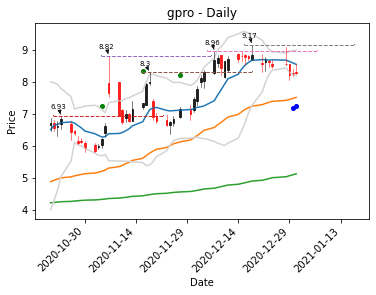

According to your risk tolerance you should allocate 0.018181829216073163% of your port now 

!!-----------!!

!!-----------!!

Stock nvda at price 522.2000122070312 is now in range of average level 513 position size 5%

[*********************100%***********************]  1 of 1 completed



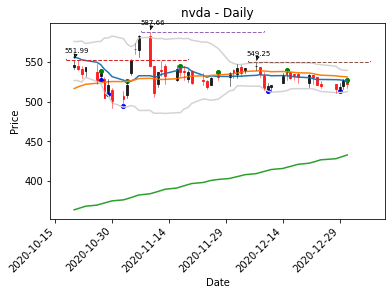

According to your risk tolerance you should allocate 0.026361751192254864% of your port now 

!!-----------!!

!!-----------!!

Stock docu at price 222.3000030517578 is now in range of average level 220 position size 2%

[*********************100%***********************]  1 of 1 completed



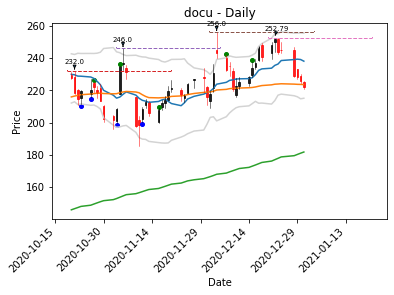

According to your risk tolerance you should allocate 0.013134322375705823% of your port now 

!!-----------!!

!!-----------!!

Stock ba at price 214.05999755859375 is now in range of average level 210 position size 2%

[*********************100%***********************]  1 of 1 completed



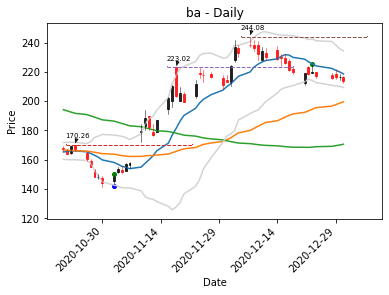

According to your risk tolerance you should allocate 0.010169494531218841% of your port now 

!!-----------!!



In [15]:
# dict of stocks and notif points for longing a stock 
stocksl = {'amzn':[3100, 3050, 2850], 'sq':[215, 210, 203, 190, 170], 'bynd':[135, 123], 'ba':[210, 200, 180], 'rkt':[19.5], 
           'lmnd':[90, 80, 64, 47], 'crsr':[33, 30, 27], 'ayx':[120, 115, 110], 'amd':[88, 82, 79], 'u':[140, 130, 116, 90], 
           'aal':[14, 12], 'etsy':[155, 140, 126, 117], 'pltr':[20, 15], 'spce':[24.5, 21], 'fsly':[85, 80, 73], 
           'chgg':[77, 67, 57], 'chwy':[80, 75, 70, 64, 58], 'net':[70, 65, 60], 'vrm':[36, 33, 31], 
           'crm':[220], 'abnb': [125], 'nvda':[500], 'pins':[64, 56], 'ftch':[51, 42], 'se':[188, 166],'ddog':[87, 78],
           'apps':[45, 40, 32],'crwd':[184, 174], 'cbat':[4.5, 3.4, 2], 'bby':[90], 'gpro':[7, 5.5], 'zi':[43, 40]}
# dict of stocks and notif points for shorting / selling a position 
stockss = {'amzn':[3500], 'sq':[240], 'bynd':[150], 'ba':[245], 'rkt':[24], 'lmnd':[110], 'crsr':[50], 'ayx':[140], 
         'amd':[100], 'u':[170], 'aal':[18], 'etsy':[200], 'pltr':[30], 'spce':[30], 'fsly':[100], 'chgg':[90],
         'chwy':[110], 'net':[90], 'vrm':[50], 'crm': [260], 'abnb':[150], 'nvda':[560, 580], 'pins':[77], 
          'ftch':[65], 'se':[220],'ddog':[122],'apps':[58],'crwd':[220], 'cbat':[8, 11], 'bby':[120, 125], 'gpro':[9],
          'zi':[500]}
# For long term portfolio, basically 90% of IBKR portfolio, other 10% used for swings. 
long_term = {'amzn':[3100, '15%'], 'gpro':[8, '5%'], 'gsky':[4, '1.5%'], 'stm':[33, '2.5%'], 'nvda':[513, '5%'], 
             'tsla':[580, '8%'], 'crwd':[160, '2%'], 'docu':[220, '2%'], 'veev':[225, '2%'], 'nls':[17, '2%'], 
             'ngms':[25, '2%'], 'abnb':[140, '10%'], 'ba':[210, '2%'], 'sq':[200, '8%'], 'u':[130, '4%']}
# Range identifies if stock is getting close to the desired average position of long terms in %'s 
stock_range = 0.04
# stores data of stocks which are below or above support / resistance: 
support = []
resistance = []
long_term_storage = []
in_range = []
# Goes through all the tickers in swings
for ticker in stocksl.keys(): 
    df=pdr.get_data_yahoo(ticker)
    # Gets todays and yesterdays prices 
    today = df['Close'][-1]
    yday = df['Close'][-2]
    # checks for break through 
    for target in stocksl[ticker]:
        if today < target < yday:
            support.append([ticker, target])
    for target in stockss[ticker]:
        if today > target > yday:
            resistance.append([ticker, target])
    # prints stock price and % change in price
    print("-----------"+str(ticker)+"-----------")
    print("Todays close: "+ str(today) + "\n" + "Yesterdays close: "+str(yday))
    print("% change in price: " + str(((today-yday)/yday)*100) + '%\n')
# Goes through all the tickers in long terms 
for ticker in long_term.keys():
    df = pdr.get_data_yahoo(ticker)
    price = df['Close'][-1]
    # Gets the range the stock can be in for notifs 
    upper_bound = long_term[ticker][0] * (1+stock_range)
    if price < long_term[ticker][0]:
        long_term_storage.append([ticker, price, long_term[ticker][0], long_term[ticker][1]])
    elif upper_bound > price:
        in_range.append([ticker, price, long_term[ticker][0], long_term[ticker][1]])
    print("-----------"+str(ticker)+"-----------")
    print("Todays close: "+ str(price) + "\n")
for values in support:
    print("!!-----------!!\n")
    print("Stock "+ str(values[0]) + " is now below support level " + str(values[1])+ ' bullish''\n')
    print("!!-----------!!\n")
for values in resistance: 
    print("!!-----------!!\n")
    print("Stock "+ str(values[0]) + " is now above resistance level " + str(values[1])+ ' bearish''\n')
    plotspy(str(values[0]))
    print("!!-----------!!\n")
for values in long_term_storage:
    print("!!-----------!!\n")
    print("Stock "+ str(values[0]) + " at price "+ str(values[1]) +" is now below average level " + 
          str(values[2])+ ' position size '+str(values[3])+'\n')
    plotspy(str(values[0]))
    print("!!-----------!!\n")
for values in in_range:
    print("!!-----------!!\n")
    print("Stock "+ str(values[0]) + " at price "+ str(values[1]) +" is now in range of average level " + 
          str(values[2])+ ' position size '+str(values[3])+'\n')
    plotspy(str(values[0]))
    print("According to your risk tolerance you should allocate "+ str(risktolerance(values)) + "% of your port now \n")
    print("!!-----------!!\n")